In [3]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import datetime

 ### yfinance 批量下载spy前10大成分股近6年数据：

 
SPY前10大成分股（2025年7月，实际成分可根据最新数据调整）
'AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'META', 'BRK-B', 'AVGO', 'TSLA', 'GOOG'

In [4]:
spy_top10 = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'META', 'BRK-B', 'AVGO', 'TSLA', 'GOOG']

start_date = (datetime.now().replace(year=datetime.now().year - 6)).strftime('%Y-%m-%d')
end_date = datetime.now().strftime('%Y-%m-%d')

# 存成 Parquet 方便后续增量更新
data = {}
for ticker in spy_top10:
    df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
    data[ticker] = df
    # 可选：保存为parquet
    if df is not None and not df.empty:
        df.to_parquet(f"tickers/{ticker}.parquet")

print(data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

{'AAPL': Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2019-07-22   49.764130   49.766530   48.897184   48.906788  89111600
2019-07-23   50.153175   50.169988   49.780940   50.061920  73420800
2019-07-24   50.112354   50.227626   49.752127   49.872203  59966400
2019-07-25   49.716099   50.249235   49.646453   50.165180  55638400
2019-07-26   49.889015   50.366914   49.744923   49.826574  70475600
...                ...         ...         ...         ...       ...
2025-07-14  208.619995  210.910004  207.539993  209.929993  38840100
2025-07-15  209.110001  211.889999  208.919998  209.220001  42296300
2025-07-16  210.160004  212.399994  208.639999  210.300003  47490500
2025-07-17  210.020004  211.800003  209.589996  210.570007  48068100
2025-07-18  211.179993  211.789993  209.699997  210.869995  48939500

[1507 rows x 5 columns],


### EDA & 可视化 

1. seaborn.pairplot 看收益分布

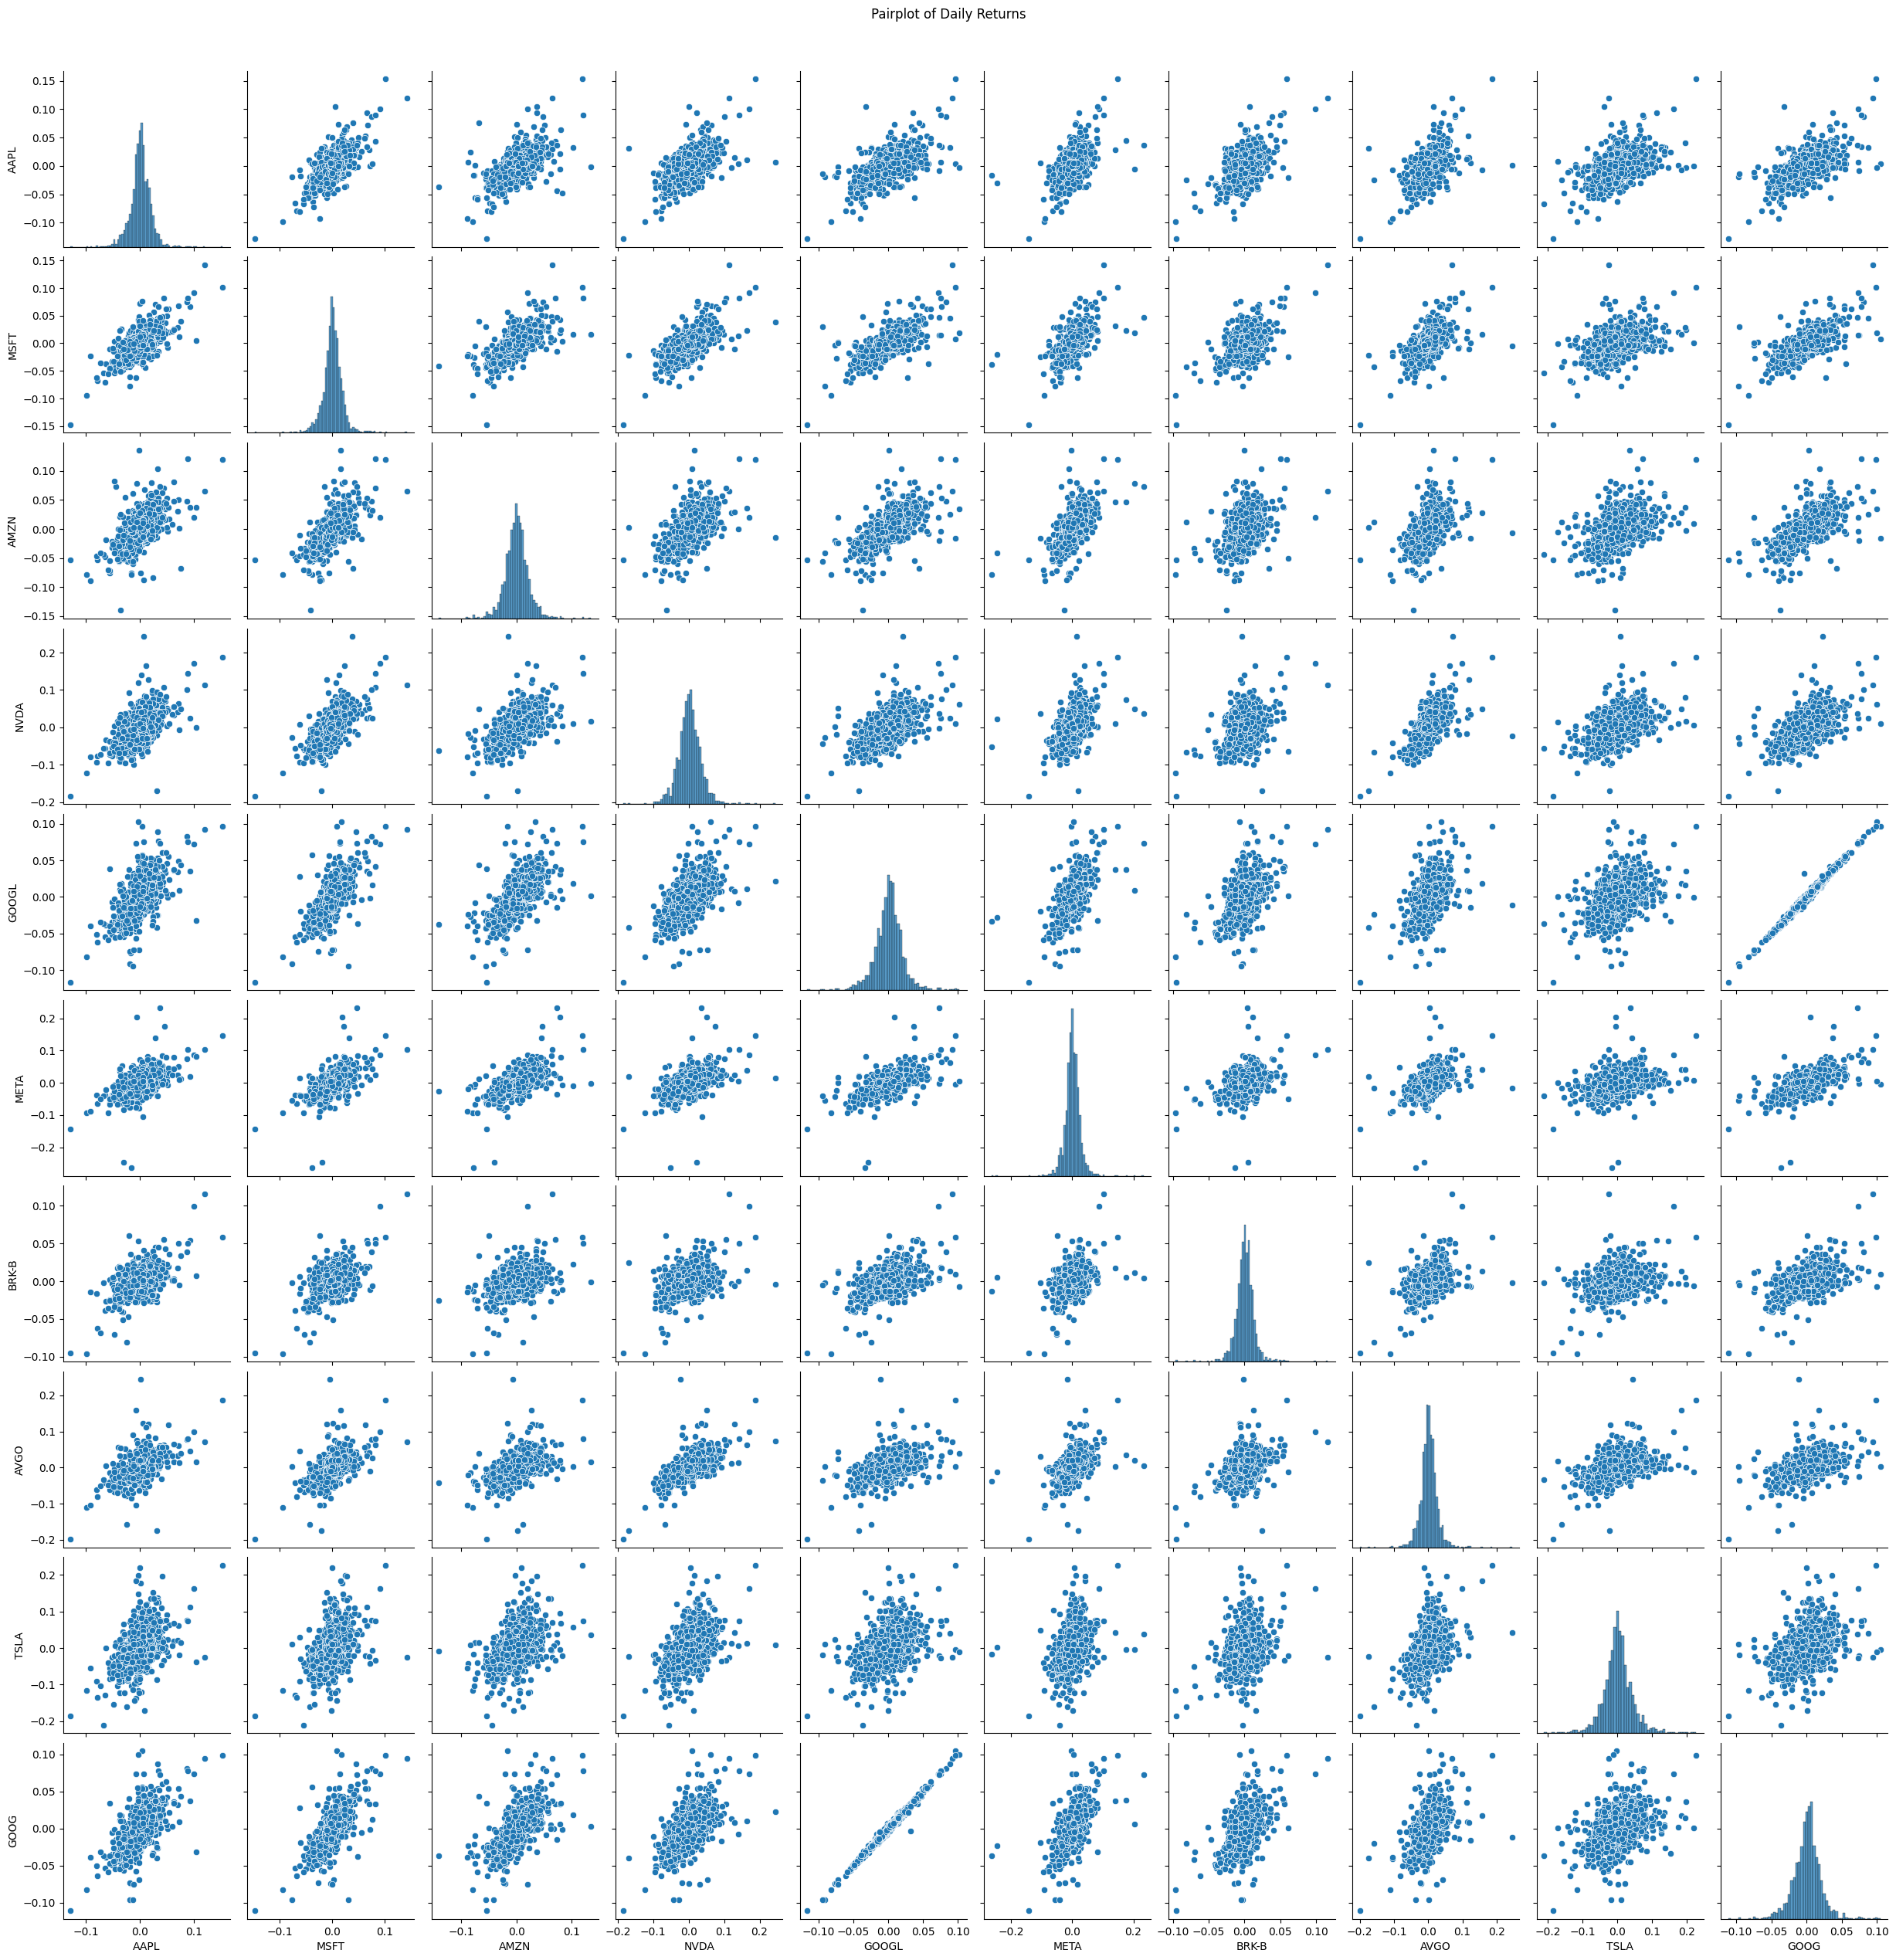

In [5]:
# 计算每日收益率
returns_list = []
for ticker, df in data.items():
    if not df.empty and len(df) > 1:
        close = df['Close']
        if isinstance(close, pd.DataFrame):
            close = close.squeeze()
        returns_list.append(close.pct_change().rename(ticker))
returns = pd.concat(returns_list, axis=1).dropna()

# 配对图
sns.pairplot(returns)
plt.suptitle('Pairplot of Daily Returns', y=1.02)
plt.show()

2. 用 Plotly 画蜡烛图

In [6]:
df.columns = df.columns.get_level_values(0)  # 下载的数据中有两行表头，只保留第一行
print(df)

fig = go.Figure(data=[
    go.Candlestick(
        x=df.index,
        open=df['Open'],
        high=df['High'],
        low=df['Low'],
        close=df['Close'],
        name=ticker
    )
])

fig.update_layout(
    title=f"{ticker}",
    xaxis_title="Date",
    yaxis_title="Price",
    width=900,
    height=400
)

fig.show()

Price            Close        High         Low        Open    Volume
Date                                                                
2019-07-22   56.567253   56.625906   55.879841   56.337619  26030000
2019-07-23   56.971851   57.006148   56.255608   56.862004  21874000
2019-07-24   56.554333   56.862006   56.016529   56.260581  31796000
2019-07-25   56.271515   56.747685   55.714826   56.554831  44196000
2019-07-26   62.151066   62.903593   60.838369   60.840356  96116000
...                ...         ...         ...         ...       ...
2025-07-14  182.809998  184.729996  180.710999  182.070007  20990400
2025-07-15  183.100006  185.410004  182.389999  183.940002  23911600
2025-07-16  183.770004  185.335007  183.080002  184.320007  21152600
2025-07-17  184.699997  185.186996  181.500000  183.115005  21654400
2025-07-18  185.940002  187.360001  184.729996  186.619995  21011300

[1507 rows x 5 columns]
